In [411]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
from scipy.optimize import curve_fit
from time import time
%matplotlib inline

Function definitions and some other parameters

In [723]:
res = 10000 # 1 sample is 1/res*1.6ms, 1e7 to resolve 311Mhz
n = 40 * res # grid size, total time
n = n-1 # To get the wave periodicity edge effects to work out

#freq = 311.25 # MHz, observed band
freq = 0.5 # Test, easier on computation
p_spin = 1.6 # ms, spin period

freq *= 1e6 #MHz to Hz
p_spin *= 1e-3 #ms to s

p_phase = 1./freq # s, E field oscillation period
R = 6.273 # s, pulsar-companion distance
gradient = 0.00133
#gradient = 60.0e-5/0.12

intime = p_spin/res # sample -> time in s conversion factor
insample = res/p_spin # time in s -> samples conversion factor

ipulsar = 18*n/32 # Pulsar position for the geometric delay, will be scanned through

t = np.linspace(0., n*intime, n) #time array

# Gaussian for fitting
def gaussian(x,a,b,c):
    return a * np.exp(-(x - c)**2/(2 * b**2))

In [724]:
# x in the following functions should be in s
# The small features in DM change are about 7.5ms wide

def tau_str(x):
#    return np.piecewise(x, [x < (n/2)*intime, x >= (n/2)*intime], [1.0e-5, 1.0e-5])
    return np.piecewise(x, [x < (n/2)*intime, x >= (n/2)*intime], [1.0e-5, lambda x: 1.0e-5+gradient*(x-(n/2)*intime)])
def tau_geom(x, xpulsar):
    return (xpulsar-x)**2/(2.*R)
def tau_phase(x, xpulsar):
    return -tau_str(x) + tau_geom(x, xpulsar)
def tau_group(x, xpulsar):
    return tau_str(x) + tau_geom(x, xpulsar)

#def tau_str(x):
#    return Piecewise((1.0e-5, x < (n/2)*intime), (1.0e-5+gradient*(x-(n/2)*intime), x >= (n/2)*intime))

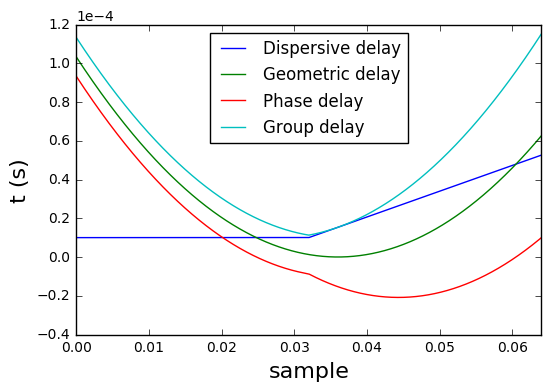

In [725]:
#plt.figure(figsize=(14,4))
plt.plot(t,tau_str(t), label="Dispersive delay")
plt.plot(t,tau_geom(t, ipulsar*intime), label="Geometric delay")
plt.plot(t,tau_phase(t, ipulsar*intime), label="Phase delay")
plt.plot(t,tau_group(t, ipulsar*intime), label="Group delay")
plt.xlim(0,n*intime)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc="best")
plt.xlabel('sample', fontsize=16)
plt.ylabel(r't (s)', fontsize=16)
plt.savefig('images/delays.png')

Load a mean pulse profile for B1957+20, and fit a gaussian to the main pulse

In [726]:
# The grid size of mean_profile.npy is 1000
mean_profile = np.load('mean_profile.npy')

meanprof_Jy = (mean_profile / np.median(mean_profile) - 1) * 12.
xarr = np.arange(1000)
popt, pcov = curve_fit(gaussian, xarr, meanprof_Jy, bounds=([-np.inf,-np.inf,800.],[np.inf,np.inf,890.]))

(-0.1, 0.8)

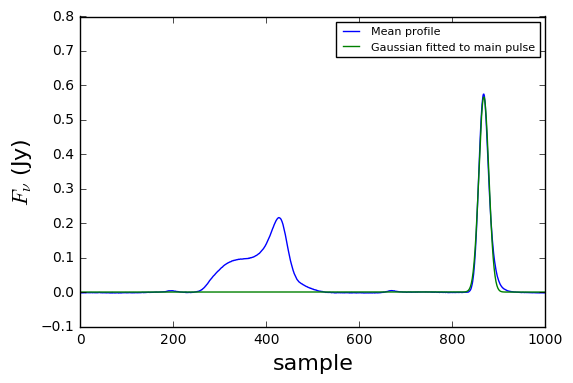

In [727]:
plt.plot(meanprof_Jy, label="Mean profile")
plt.plot(xarr, gaussian(xarr, *popt), label="Gaussian fitted to main pulse")
plt.legend(loc="best", fontsize=8)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
plt.xlim(0,1000)
plt.ylim(-.1, 0.8)
plt.savefig('images/gaussfit_MP.png')

Isolate the main pulse, sqrt it, and center

In [728]:
xarr = np.arange(n)

pulse_params = popt
pulse_params[1] *= res/1000 # resizing the width to current gridsize
pulse_params[2] = n/2 # centering

pulse_ref = gaussian(xarr, *pulse_params)
envel_ref = np.sqrt(pulse_ref)

(-0.1, 0.8)

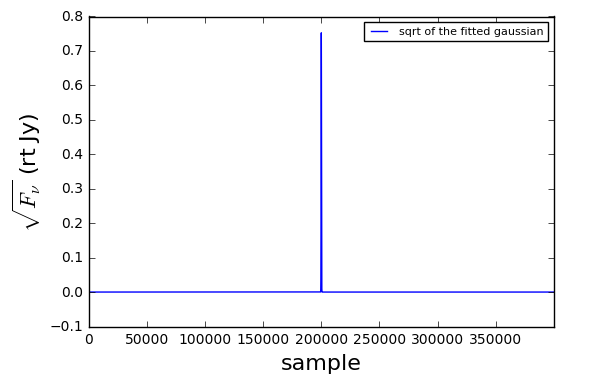

In [729]:
plt.plot(envel_ref, label="sqrt of the fitted gaussian")
plt.legend(loc="upper right", fontsize=8)
plt.xlabel('sample', fontsize=16)
plt.ylabel(r'$\sqrt{F_{\nu}}$ (rt Jy)', fontsize=16)
plt.xlim(0,n)
plt.ylim(-.1, 0.8)
plt.savefig('images/gaussfit_center.png')

Invent some sinusoidal wave at frequency of observed band. Assuming waves of the form e^(i \omega t)

In [730]:
angular_freq = 2*np.pi*freq
phase_ref = np.exp(1j*angular_freq*t)
print phase_ref[0], phase_ref[-1]

(1+0j) (0.876306680045-0.4817536741j)


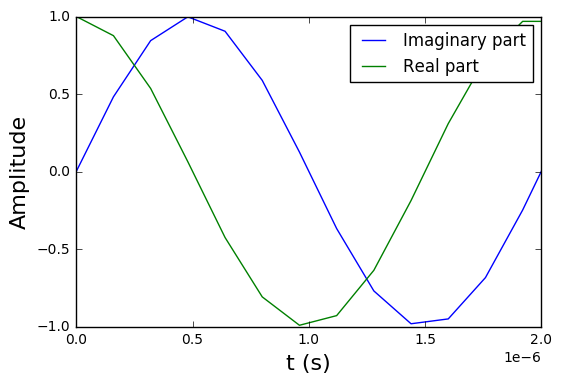

In [731]:
#phase_ref = np.roll(phase_ref,3)
plt.plot(t, phase_ref.imag, label="Imaginary part")
plt.plot(t, phase_ref.real, label="Real part")
plt.xlim(0, 1*1./freq)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend(loc="upper right")
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'Amplitude', fontsize=16)
plt.savefig('images/oscillations.png')

Compute an electric field

In [732]:
a = 109797  # rt(kg)*m/s^2/A; a = sqrt(2*16MHz/(c*n*epsilon_0)), conversion factor between
            # sqrt(Jansky) and E field strength assuming n=1 and a 16MHz bandwidth

b = 1e-13   # rt(kg)/s; a*b = 1.1e-8 V/m

E_field_ref = a*b*envel_ref*phase_ref
E_field_ref = np.roll(E_field_ref, (int)(1e-5*insample))

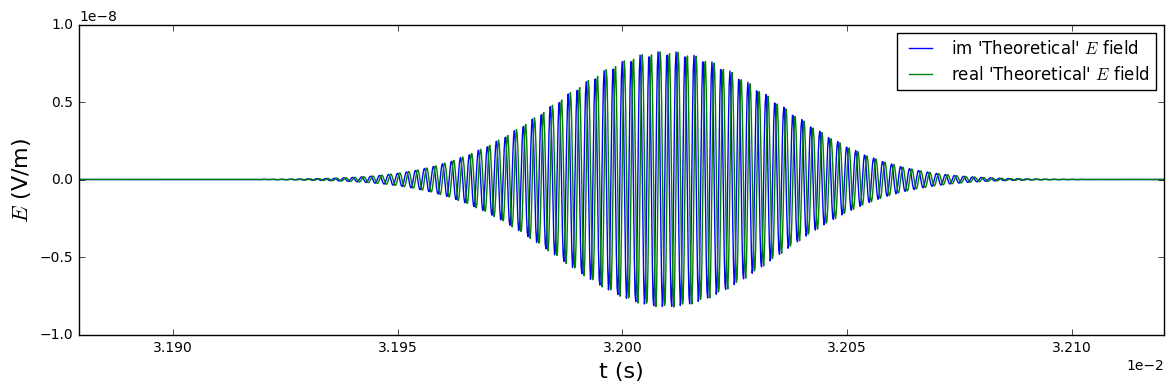

In [733]:
plt.figure(figsize=(14,4))
#plt.plot(t, np.abs(E_field_ref), label="\'Theoretical\' $E$ field")
plt.plot(t, np.real(E_field_ref), label="im \'Theoretical\' $E$ field")
plt.plot(t, np.imag(E_field_ref), label="real \'Theoretical\' $E$ field")
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlim((n/2-7*pulse_params[1])*intime,(n/2+7*pulse_params[1])*intime)
plt.legend(loc="best")
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)
plt.savefig('pulse_E_field.png')

Now we have to delay the phase and the pulse(group) and integrate. We will parallelize it so we don't have to wait too long.

In [734]:
k_int = 30 # Integration range = +- period*k_int
lim = (int)(np.sqrt(k_int*p_phase*2*R)*insample) # How far does tau_geom have to go to get to k_int periods of E oscillation

# The last argument should be >> 2*k_int (m) to resolve oscillations of E
#int_domain = np.linspace(ipulsar-lim, ipulsar+lim, 3000*np.sqrt(k_int))
int_domain = np.linspace(0,0.064*insample,20000)
#int_domain = (np.random.random(10000)*2*lim)-lim
#print lim, (int)(tau_geom(np.amax(int_domain)*intime, n/2*intime)*insample)

def delay_field(i):
    phase = np.roll(phase_ref, (int)(tau_phase(i*intime, ipulsar*intime)*insample))
    padsize = (int)(tau_group(i*intime, ipulsar*intime)*insample)
    envel = np.pad(envel_ref, (padsize,0), mode='constant')[:-padsize]
    #envel = np.roll(envel_ref, (int)(tau_group(i*intime, ipulsar*intime)*insample))
    E_field = a*b*phase*envel
    return E_field

def delay_field_flat(i):
    phase = np.roll(phase_ref, (int)((-1.0e-5+tau_geom(i*intime, ipulsar*intime))*insample))
    padsize = (int)(( 1.0e-5+tau_geom(i*intime, ipulsar*intime))*insample)
    envel = np.pad(envel_ref, (padsize,0), mode='constant')[:-padsize]
    #envel = np.roll(envel_ref, (int)(( 1.0e-5+tau_geom(i*intime, ipulsar*intime))*insample))
    E_field = a*b*phase*envel
    return E_field

In [735]:
#This was used to find the optimal k_int, it seems to be around 30 for this particular frequency

#heightprev = 10
#error = 10
#k = 31
#heights = []
#while error > 0.0001 and k < 100:
#    E_tot = np.zeros(n, dtype=np.complex128)
#    lim = (int)(np.sqrt(k*p_phase*2*R)*insample)
#    int_domain = np.linspace(-lim, lim, 10000*np.sqrt(k))
#    for i in int_domain:
#        E_tot += delay_field(i)
#    
#    popt3, pcov3 = curve_fit(gaussian, xarr, np.abs(E_tot), bounds=([-np.inf,-np.inf,n/2-n/15],[np.inf,np.inf,n/2+n/15]))
#    heights.append(popt3[0])
#    error = np.abs(popt3[0]-heightprev)/heightprev
#    print k, popt3[0], popt3[1], popt3[2]
#    heightprev = popt3[0]
#   k += 1
#print "Stopped with error = ", error
#plt.plot(heights)

In [736]:
E_tot_flat = np.zeros(n, dtype=np.complex128)
E_tot = np.zeros(n, dtype=np.complex128)

print 'Integrating with', int_domain.size, 'samples'
print 'Total size', n
print 'Integration range', ipulsar, "+-", lim
print 'Integration range', ipulsar*intime*1e3, "+-", lim*intime*1e3, 'ms'
print 'Integration range in y +-', tau_geom(lim*intime, ipulsar*intime)*1e6, 'us'

tick = time()

for i in int_domain:
    E_tot += delay_field(i)
    E_tot_flat += delay_field_flat(i)

print 'Time elapsed:', time() - tick, 's'

Integrating with 20000 samples
Total size 399999
Integration range 224999 +- 171477
Integration range 35.99984 +- 27.43632 ms
Integration range in y +- 5.84519964853 us
Time elapsed: 320.03490901 s


In [737]:
print np.amax(np.abs(E_field_ref)), np.amax(np.abs(E_tot))

8.26322088159e-09 9.06772135025e-06


In [721]:
# This parallelizes really terribly for some reason.... Maybe take a look later.
# Possibly because this is in a notebook?

# The if is required apparently so we don't get an infinite loop (in Windows in particular)

#import multiprocessing
#E_tot = np.zeros(n, dtype=np.complex128)
#if __name__ == '__main__':
#    pool = multiprocessing.Pool()
#    print multiprocessing.cpu_count()
#    currenttime = time()
#    E_tot = sum(pool.imap_unordered(delay_field, ((i) for i in int_domain), chunksize=int_domain.size/16))
#    print 'Time elapsed:', time() - currenttime
#    pool.close()
#    pool.join()



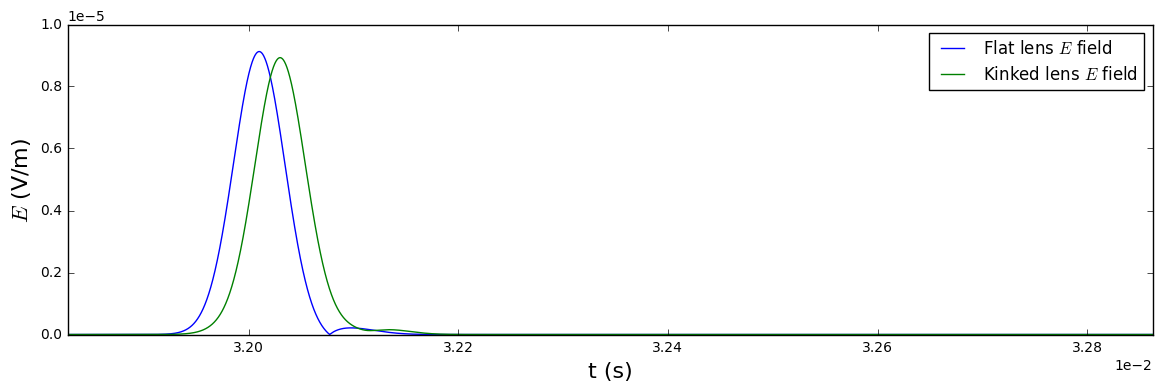

In [722]:
plt.figure(figsize=(14,4))
#plt.plot(t.reshape(-1,1e3).mean(axis=1), E_tot.reshape(-1,1e3).mean(axis=1)) # downsampling before plotting.
plt.plot(t, np.abs(E_tot_flat), label="Flat lens $E$ field")
plt.plot(t, np.abs(E_tot), label="Kinked lens $E$ field")
plt.xlim((n/2-10*pulse_params[1])*intime,(n/2+50*pulse_params[1])*intime)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.legend(loc="best")
plt.xlabel('t (s)', fontsize=16)
plt.ylabel(r'$E$ (V/m)', fontsize=16)
plt.savefig('images/lensed_pulse.png')

Now, we have to backfit the integrated pulse back onto the observational data

In [176]:
#E_tot *= np.amax(np.abs(E_field_ref))/np.amax(np.abs(E_tot)) # this scaling is ad-hoc, really should do it for the pre-lensed E field

In [145]:
#pulse_tot = E_tot * np.conjugate(E_tot) / (a*b)**2
#if np.imag(pulse_tot).all() < 1e-50:
#    pulse_tot = np.real(pulse_tot)
#else:
#    print 'Not purely real, what\'s going on?'

In [146]:
# Check if it's still gaussian by fitting a gaussian
#pulse_tot = pulse_tot.reshape(-1,n/1000).mean(axis=1)
#popt2, pcov2 = curve_fit(gaussian, x, pulse_tot, bounds=([-np.inf,-np.inf,400.],[np.inf,np.inf,600.]))#

NameError: name 'x' is not defined

In [ ]:
#plt.plot(np.roll(meanprof_Jy,-1000/3-22), label="Mean profile main pulse") # This fitting is also ad-hoc, should do least square?
#plt.plot(xarr, gaussian(xarr, popt[0], popt[1], popt2[2]), label="Gaussian fitted to main pulse")
#plt.plot(pulse_tot, label="Integrated refitted curve")
#plt.plot(xarr, gaussian(xarr, *popt2), label="Gaussian fitted to integrated curve (overlaps)") # Looks like it's still gaussian
#plt.legend(loc="best", fontsize=7)
#plt.xlabel('sample', fontsize=16)
#plt.ylabel(r'$F_{\nu}$ (Jy)', fontsize=16)
#plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
#plt.xlim(450,580)
#plt.ylim(-.1, .8)